<h1 style=" text-align : center;  font-family: 'SF Mono'; color: purple;"><b>MIDTERM CODING - ECONOMIC FORECASTING </b></h1>


#### DATA PREPROCESSING

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.available
plt.style.use("seaborn-v0_8-whitegrid")

In [64]:
dataset = pd.read_excel("eforcast_data/datasetalcohol - stata.xlsx")
dataset

,Date,Sales
0,37987,5629
1,38018,5898
2,38047,7045
3,38078,7094
4,38108,7333
...,...,...
103,41122,11163
104,41153,9532
105,41183,10754
106,41214,10953


In [54]:
dataset = dataset.sort_values(by='Date', ascending=True)
dataset

,Date,Sales
0,37987,5629
1,38018,5898
2,38047,7045
3,38078,7094
4,38108,7333
...,...,...
103,41122,11163
104,41153,9532
105,41183,10754
106,41214,10953


In [55]:
for col in dataset.columns:
    missing_data = dataset[col].isna().sum()
    missing_per = missing_data /len(dataset)*100
    print(f"Column {col} has {missing_per}% missing data")

Column Date has 0.0% missing data
Column Sales has 0.0% missing data


<Axes: >

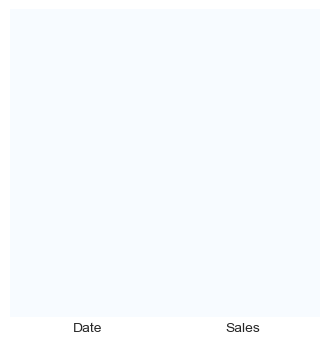

In [56]:
import seaborn as sns
plt.figure(figsize = (4,4))
sns.heatmap(dataset.isna(), cbar = False, cmap = "Blues", yticklabels = False )

#### DATA VISUALIZATION

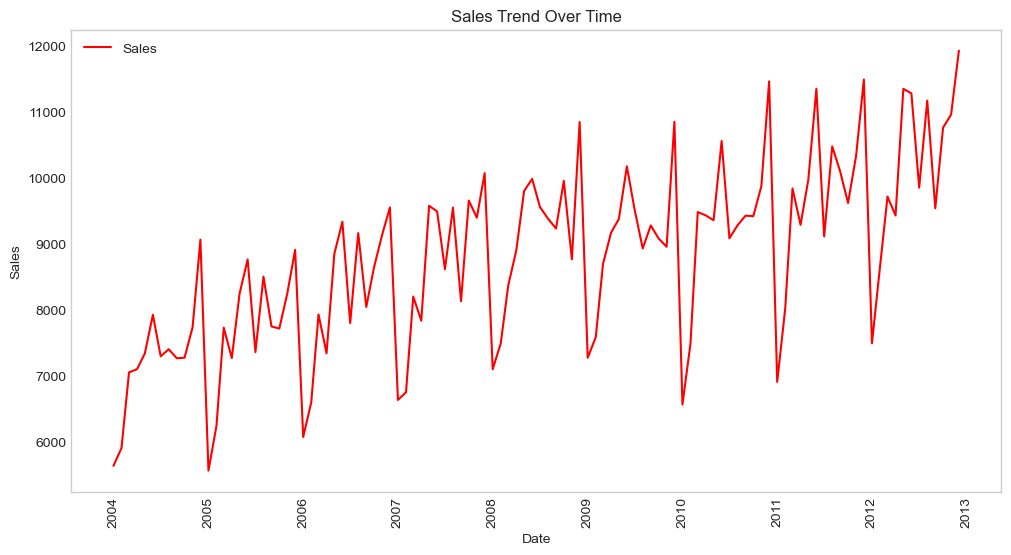

In [62]:
dataset["Date"] = pd.to_datetime(dataset["Date"], origin="1899-12-30", unit="D")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dataset["Date"], dataset["Sales"], color="r", label="Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Trend Over Time")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

### MOVING AVERAGE 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file Excel
data = pd.read_excel("eforcast_data/datasetalcohol - stata.xlsx")
df = pd.DataFrame(data)

def moving_average_forecast(series, window_size):
    forecasts = [None] * window_size
    rolling_means = series.rolling(window=window_size).mean().iloc[window_size - 1:-1]
    forecasts.extend(rolling_means.tolist())
    return forecasts

def compute_error_metrics(actual, predicted):
    differences = actual - predicted
    mae = differences.abs().mean()
    mse = (differences ** 2).mean()
    mape = (differences.abs() / actual).mean()
    return mae, mse, mape

window_range = range(2, 101)
metrics_summary = {}

for w in window_range:
    df['Predicted'] = moving_average_forecast(df['Sales'], w)
    valid_data = df.dropna(subset=['Predicted'])
    mae, mse, mape = compute_error_metrics(valid_data['Sales'], valid_data['Predicted'])
    metrics_summary[w] = {'MAE': mae, 'MSE': mse, 'MAPE': mape}

lowest_mae = min(metrics_summary.values(), key=lambda x: x['MAE'])['MAE']
lowest_mse = min(metrics_summary.values(), key=lambda x: x['MSE'])['MSE']
lowest_mape = min(metrics_summary.values(), key=lambda x: x['MAPE'])['MAPE']

for w in metrics_summary:
    metrics_summary[w]['Combined_Score'] = (metrics_summary[w]['MAE'] / lowest_mae +
                                           metrics_summary[w]['MSE'] / lowest_mse +
                                           metrics_summary[w]['MAPE'] / lowest_mape)

optimal_window = min(metrics_summary, key=lambda x: metrics_summary[x]['Combined_Score'])
optimal_results = metrics_summary[optimal_window]

print(f"Optimal window size: {optimal_window}")
print(f"MAE: {optimal_results['MAE']:.4f}")
print(f"MSE: {optimal_results['MSE']:.4f}")
print(f"MAPE: {optimal_results['MAPE']:.4f}")

Optimal window size: 13
MAE: 836.5401
MSE: 1104727.3525
MAPE: 0.0954


### WEIGHTED MOVING AVERAGE

In [65]:
import pandas as pd
import numpy as np
from itertools import product

data = pd.read_excel("eforcast_data/datasetalcoholforwma.xlsx")
df = pd.DataFrame(data)

def calculate_weighted_forecast(series, weight_sets, window):
    forecasts = {}
    for idx, weights in enumerate(weight_sets):
        forecast = [None]  
        for i in range(1, len(series)):
            if i < window:
                available = series[:i]
                sub_weights = np.array(weights[-i:])
                sub_weights = sub_weights / sub_weights.sum()  # rescale lại cho tổng = 1
                f_val = sum(available[j] * sub_weights[j] for j in range(i))
            else:
                available = series[i - window:i]
                f_val = sum(available[j] * weights[j] for j in range(window))
            forecast.append(f_val)
        forecasts[f'Forecast_{window}_{idx+1}'] = forecast
    return forecasts

def generate_weight_sets(window):
    valid_weights = []
    for w in product([i / 10 for i in range(1, 10)], repeat=window):
        if round(sum(w), 1) == 1.0:
            valid_weights.append(list(w))
    return valid_weights

best_forecasts = []
for window in range(2, 6):
    weight_sets = generate_weight_sets(window)
    forecast_results = calculate_weighted_forecast(df['Sales'].values, weight_sets, window)
    
    temp_forecasts_df = pd.DataFrame(forecast_results)

    metrics = []
    for idx, key in enumerate(forecast_results.keys()):
        forecast_values = temp_forecasts_df[key]

        error = df['Sales'] - forecast_values
        abs_error = error.abs()
        squared_error = abs_error ** 2
        percentage_error = abs_error / df['Sales']
        
        MAE = abs_error.mean()      
        MSE = squared_error.mean() 
        MAPE = percentage_error.mean() 
        
        metrics.append((key, weight_sets[idx], MAE, MSE, MAPE))
    
    df = pd.concat([df, temp_forecasts_df], axis=1)
    
    min_MAE = min(metrics, key=lambda x: x[2])
    min_MSE = min(metrics, key=lambda x: x[3])
    min_MAPE = min(metrics, key=lambda x: x[4])
    
    best_forecasts.extend([min_MAE, min_MSE, min_MAPE])

unique_best_forecasts = list({x[0]: x for x in best_forecasts}.values())

for key, weights, MAE, MSE, MAPE in unique_best_forecasts:
    print(f"{key} {weights}:")
    print(f"MAE: {MAE:.4f}\tMSE: {MSE:.4f}\tMAPE: {MAPE:.4f}\n")


Forecast_2_2 [0.2, 0.8]:
MAE: 927.8935	MSE: 1636158.5693	MAPE: 0.1114

Forecast_2_4 [0.4, 0.6]:
MAE: 957.6318	MSE: 1557619.1802	MAPE: 0.1151

Forecast_3_16 [0.3, 0.1, 0.6]:
MAE: 886.7507	MSE: 1403678.7722	MAPE: 0.1060

Forecast_3_17 [0.3, 0.2, 0.5]:
MAE: 911.6846	MSE: 1374998.9083	MAPE: 0.1091

Forecast_4_8 [0.1, 0.2, 0.1, 0.6]:
MAE: 888.7013	MSE: 1419285.5900	MAPE: 0.1060

Forecast_4_15 [0.1, 0.3, 0.2, 0.4]:
MAE: 918.6323	MSE: 1366769.9053	MAPE: 0.1095

Forecast_5_92 [0.3, 0.1, 0.1, 0.1, 0.4]:
MAE: 851.0001	MSE: 1333172.4811	MAPE: 0.1012

Forecast_5_62 [0.2, 0.1, 0.2, 0.1, 0.4]:
MAE: 854.4895	MSE: 1305860.0717	MAPE: 0.1016

